<a href="https://colab.research.google.com/github/mz-zarei/CGAN_Augmentation/blob/main/RealDataAugmentation_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1-Import Libs**

In [152]:
import nbeb
import importlib
import numpy as np
import random
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ELU, ReLU, concatenate
from keras.layers import Dropout
from matplotlib import pyplot
from keras import Input, Model
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


##################################################################################### GAN training Functions
# define the standalone discriminator model
def define_discriminator(in_shape=(7,)):
    y = Input(shape=(x_size,), dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    label = Input(shape=(1,))
    label_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(label)

    concat = concatenate([y_output, label_output])
    concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    validity = Dense(1, activation="sigmoid", kernel_initializer=random_uniform)(concat)

    model = Model(inputs=[y, label], outputs=validity)

    # compile model
    opt = Adam(learning_rate=dis_lr, beta_1=0.5, decay=dis_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, in_shape=1):
    y = Input(shape=in_shape, dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    noise = Input(shape=(latent_dim,))
    noise_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(noise)

    concat = concatenate([y_output, noise_output])

    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(x_size, activation="relu", kernel_initializer=random_normal)(output)

    model = Model(inputs=[noise, y], outputs=output)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get output from the generator model
    gen_output = g_model.output
    # connect output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=gen_lr, beta_1=0.5, decay=gen_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training set
def load_real_samples(x_train,y_train):

    trainX = x_train.to_numpy()
    trainY = y_train.to_numpy()

    return [trainX, trainY]

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset[0].shape[0], n_samples)
    # retrieve selected images
    X, labels = dataset[0][ix], dataset[1][ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return [X, labels], y

# generate emipircal distribution of real y samples
def generate_y_labels(y_train, size):
    y_train = y_train.tolist()

    min_y = min(y_train)
    max_y = max(y_train)

    y_list = range(min_y, max_y+1)
    y_prob_list = []


    for y in y_list:
        y_prob = y_train.count(y)/len(y_train)
        y_prob_list.append(y_prob)

    for i, prob in enumerate(y_prob_list):
        if prob == 0:
            y_prob_list[i] = y_prob_list[len(y_prob_list)-1]
    
    y_prob_list_normalized = [float(i)/sum(y_prob_list) for i in y_prob_list]


    sample_label = np.random.choice(y_list, size=size, p=y_prob_list_normalized)
    return sample_label




# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples) #randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    idx = np.random.randint(0, x_train1.shape[0], n_samples)
    labels = dataset[1][idx]
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    samples = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [samples, labels_input], y

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='Dis loss real')
    pyplot.plot(d2_hist, label='Dis loss fake')
    pyplot.plot(g_hist, label='Gen loss')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = '/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    d1_hist, d2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        # evaluate the model performance, sometimes
        if (i+1) % 500 == 0 and (i+1) > 1000:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            print('Epoch: %d, dLoss real = %.3f, dLoss fake = %.3f, gLoss = %.3f' % (i+1, d_loss1, d_loss2, g_loss))
    plot_history(d1_hist, d2_hist, g_hist)
    return d1_hist, d2_hist, g_hist




seed = 42
random.seed(seed)
np.random.seed(seed)
kerner_initializer = keras.initializers.he_normal(seed=seed)
random_uniform = keras.initializers.RandomUniform(seed=seed)
random_normal = keras.initializers.RandomNormal(seed=seed)
latent_dim, x_size = 2, 2
activation = "elu"

# **2- Prepare Test Train Crash Data**

,index,Geo_ID,Name,Group,Year,Fmaj,Fmin,Ftot,Fatal,Non-fatal,PDO,FI,Obs,Log_Fmin,Log_Fmaj
0,100,INT6303,WESTMINSTER DR @ WONDERLAND RD S,3,2017,7739.0,950.0,8689.0,0,0,2,0,2,6.856462,8.954028
1,101,INT3,CLARKE RD @ SUNNINGDALE RD E,3,2017,6702.0,2273.0,8975.0,0,2,3,2,5,7.728856,8.810161
2,102,INT388,FANSHAWE PARK RD E@STONEYBROOK CRES (1),3,2017,35173.0,682.0,35855.0,0,1,1,1,2,6.525030,10.468034
3,103,INT1927,MANITOBA ST @ WHITNEY ST,3,2017,676.0,359.0,1035.0,0,0,0,0,0,5.883322,6.516193
4,104,INT6180,DINGMAN DR @ WHITE OAK RD,3,2017,2769.0,2678.0,5447.0,0,0,0,0,0,7.892826,7.926242


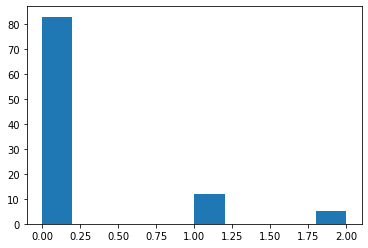

In [96]:
target = 'FI'
London_Data = pd.read_excel('/content/London_Python_Data.xlsx')
London_Data = London_Data[(London_Data['Year']==2017) & (London_Data['Group']== 3)]
#Shuffling the data
London_Data = London_Data.sample(frac = 1).reset_index(drop=True)
London_Data['Log_Fmin'] = np.log(London_Data['Fmin'])
London_Data['Log_Fmaj'] = np.log(London_Data['Fmaj'])

x_columns = ['Log_Fmin', 'Log_Fmaj']
test_data = London_Data[:100].reset_index()
y_test = test_data[target]
x_test = test_data[x_columns]


CrashData = London_Data[100:].reset_index()

ax = plt.hist(CrashData[target])
CrashData.head()


In [4]:
London_Data.describe()

,Group,Year,Fmaj,Fmin,Ftot,Fatal,Non-fatal,PDO,FI,Obs,Log_Fmin,Log_Fmaj
count,200.0,200.0,200.000000,200.000000,200.00000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.0,2017.0,7454.760000,1321.730000,8776.49000,0.0,0.220000,0.915000,0.220000,1.135000,6.779492,8.189054
std,0.0,0.0,9172.707384,1188.224192,9392.64036,0.0,0.550559,1.366423,0.550559,1.667537,1.003524,1.278557
min,3.0,2017.0,170.000000,7.000000,309.00000,0.0,0.000000,0.000000,0.000000,0.000000,1.945910,5.135798
25%,3.0,2017.0,1448.750000,490.500000,2070.25000,0.0,0.000000,0.000000,0.000000,0.000000,6.195424,7.278456
50%,3.0,2017.0,3070.500000,955.000000,4685.00000,0.0,0.000000,0.000000,0.000000,1.000000,6.861698,8.029595
75%,3.0,2017.0,10329.250000,1847.500000,12668.25000,0.0,0.000000,1.000000,0.000000,2.000000,7.521588,9.242725
max,3.0,2017.0,45691.000000,6195.000000,45952.00000,0.0,3.000000,10.000000,3.000000,11.000000,8.731498,10.729657


# **3-Train GAN**

>Accuracy real: 78%, fake: 48%
Epoch: 1500, dLoss real = 0.691, dLoss fake = 0.699, gLoss = 0.692
>Accuracy real: 39%, fake: 61%
Epoch: 2000, dLoss real = 0.692, dLoss fake = 0.701, gLoss = 0.694
>Accuracy real: 40%, fake: 56%
Epoch: 2500, dLoss real = 0.699, dLoss fake = 0.695, gLoss = 0.694
>Accuracy real: 58%, fake: 47%
Epoch: 3000, dLoss real = 0.693, dLoss fake = 0.696, gLoss = 0.693
>Accuracy real: 28%, fake: 63%
Epoch: 3500, dLoss real = 0.693, dLoss fake = 0.695, gLoss = 0.693
>Accuracy real: 59%, fake: 48%
Epoch: 4000, dLoss real = 0.693, dLoss fake = 0.696, gLoss = 0.693
>Accuracy real: 6%, fake: 97%
Epoch: 4500, dLoss real = 0.695, dLoss fake = 0.693, gLoss = 0.695
>Accuracy real: 56%, fake: 67%
Epoch: 5000, dLoss real = 0.693, dLoss fake = 0.694, gLoss = 0.694


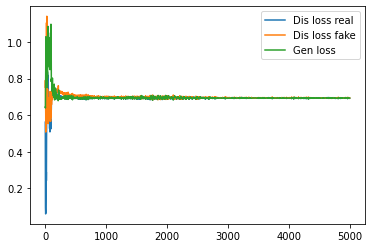

In [167]:
y_train1 = CrashData[target]
x_train1 = CrashData[x_columns]


gen_lr, dis_lr, gen_dec, dis_dec, n_epochs, n_batch = 0.001, 0.001, 0.001, 0.001, 5000, int(100)  # FI crash

# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(x_train1,y_train1)
# # train model
d1_hist, d2_hist, g_hist = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

# **4-Fit and Compare NB models**

## **Fit NB model with original data size**

In [168]:
## NB model with train data
y_train1 = CrashData[target]
x_train1 = CrashData[x_columns]

sig_fit = nbeb.forward_regression(CrashData,x_columns, y_name=target)

NB_model1, alpha1  = nbeb.fitNB(CrashData, sig_fit, y_name=target)

y_test_pred_NB1 = NB_model1.predict(sm.add_constant(x_test[sig_fit]))
y_pred_NB1 = NB_model1.predict(sm.add_constant(CrashData[sig_fit]))
test_data['y_test_pred_NB1'] = y_test_pred_NB1
mae_NB1, mape_NB1, r2_NB1 = round(mean_absolute_error(y_test, y_test_pred_NB1),3), round(nbeb.MAPE(y_test.to_numpy(), y_test_pred_NB1),3), round(r2_score(y_test, y_test_pred_NB1),3)

print("Test Set  --- MAE: ", mae_NB1, "| MAPE: ", mape_NB1, "| R2 score: ", r2_NB1, " | Alpha: ", alpha1)
print(NB_model1.summary2())

Test Set  --- MAE:  0.347 | MAPE:  0.942 | R2 score:  0.076  | Alpha:  0.5387182453564245
              Results: Generalized linear model
Model:              GLM              AIC:            112.5645 
Link Function:      log              BIC:            -389.2373
Dependent Variable: FI               Log-Likelihood: -54.282  
Date:               2022-01-25 02:15 LL-Null:        -57.877  
No. Observations:   100              Deviance:       62.069   
Df Model:           1                Pearson chi2:   101.     
Df Residuals:       98               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
const      -6.1235    1.8321  -3.3423  0.0008  -9.7144  -2.5326
Log_Fmaj    0.5400    0.2063   2.6183  0.0088   0.1358   0.9443



## **Fit NB model with CGAN augmented data size**

In [193]:
# load GAN model
model_path = '/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/'
model = load_model(model_path + 'generator_model_4500.h5')
dataset = load_real_samples(x_train1, y_train1)

# generate samples
latent_points = generate_latent_points(latent_dim, 5000)
# generate images
Fake_data = model.predict(latent_points)
fake = pd.DataFrame(Fake_data, columns=x_columns)
fake[target] = latent_points[1]


## NB model with real and fake data
# Find significant features
concat_data = pd.concat([CrashData, fake])
x_train2 = concat_data[x_columns]
y_train2 = concat_data[target]
significant_features2 = nbeb.forward_regression(concat_data, x_columns, y_name=target, threshold_in=0.05, verbose=False) 

NB_model2, alpha2 = nbeb.fitNB(concat_data, significant_features2, y_name=target)

y_pred_NB2 = NB_model2.predict(sm.add_constant(x_train1[significant_features2]))
y_test_pred_NB2 = NB_model2.predict(sm.add_constant(x_test[significant_features2]))
test_data['y_test_pred_NB2'] = y_test_pred_NB2


mae_NB2, mape_NB2, r2_NB2 = round(mean_absolute_error(y_test, y_test_pred_NB2),3), round(nbeb.MAPE(y_test.to_numpy(), y_test_pred_NB2),3), round(r2_score(y_test, y_test_pred_NB2),3)
print("Test Set  --- MAE: ", mae_NB2, "| MAPE: ", mape_NB2, "| R2 score: ", r2_NB2, " | Alpha: ", alpha2)

print(NB_model2.summary2())

# fake[x_columns].hist(bins=20, figsize = (10,5))

Test Set  --- MAE:  0.337 | MAPE:  0.904 | R2 score:  0.104  | Alpha:  0.5994308925507361
               Results: Generalized linear model
Model:              GLM              AIC:            5413.8023  
Link Function:      log              BIC:            -40500.1134
Dependent Variable: FI               Log-Likelihood: -2703.9    
Date:               2022-01-25 02:20 LL-Null:        -2935.6    
No. Observations:   5100             Deviance:       3013.0     
Df Model:           2                Pearson chi2:   4.24e+03   
Df Residuals:       5097             Scale:          1.0000     
Method:             IRLS                                        
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
const       -8.3727    0.3347  -25.0140  0.0000  -9.0287  -7.7167
Log_Fmaj     0.5839    0.0346   16.8846  0.0000   0.5161   0.6517
Log_Fmin   

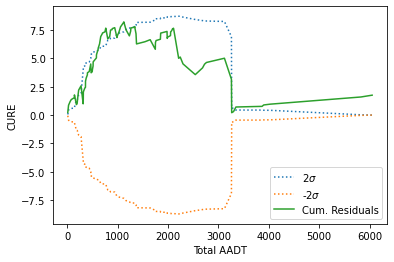

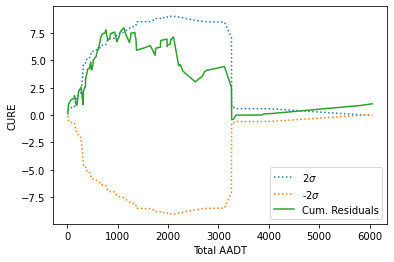

In [194]:
# CURE plot

def CURE(data, y_name= 'Obs', ftot='Ftot', y_pred = 'y_pred'):
    data.sort_values(by=ftot, ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)

    data['res'] = data[y_pred] - data[y_name]
    data['res_sq'] = (data[y_pred] - data[y_name])**2

    data['e1'] = data['res'].cumsum()
    data['e2'] = data['res_sq'].cumsum()
    data['e3'] = data['e2']*((1 - data['e2']/data['e2'][len(data['e2'])-1]))

    plt.plot(data[ftot], data['e3'], linestyle = 'dotted', label = "2$\sigma$")
    plt.plot(data[ftot], -data['e3'], linestyle = 'dotted', label = "-2$\sigma$")
    plt.plot(data[ftot], data['e1'], label = "Cum. Residuals")
    plt.legend(loc='lower right')
    plt.xlabel('Total AADT')
    plt.ylabel('CURE')
    plt.show()

CURE(test_data, y_name= target, ftot='Fmin', y_pred = 'y_test_pred_NB1')
CURE(test_data, y_name= target, ftot='Fmin', y_pred = 'y_test_pred_NB2')


In [188]:
## Statistical tests
from scipy import stats

for att in ['Log_Fmin', 'Log_Fmaj']:
    print(att)
    fake_sample = fake[att].sample(30).values
    real_sample = London_Data[att].sample(30).values

    ## T-test for mean
    print(stats.ttest_ind(fake_sample, real_sample))
    ## Leven Test for variance
    print(stats.levene(fake_sample, real_sample))
    ## KS Test for distrbution
    print(stats.ks_2samp(fake_sample, real_sample))


Log_Fmin
Ttest_indResult(statistic=0.5060939503060868, pvalue=0.6147090016037384)
LeveneResult(statistic=0.20370809071510118, pvalue=0.6534274001884711)
Ks_2sampResult(statistic=0.16666666666666666, pvalue=0.8079631540901643)
Log_Fmaj
Ttest_indResult(statistic=-0.6698064277124064, pvalue=0.5056391726536708)
LeveneResult(statistic=1.8813616567370184, pvalue=0.175462423916806)
Ks_2sampResult(statistic=0.23333333333333334, pvalue=0.39294501397971776)


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


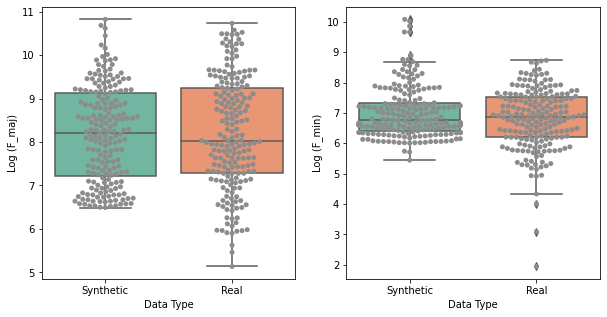

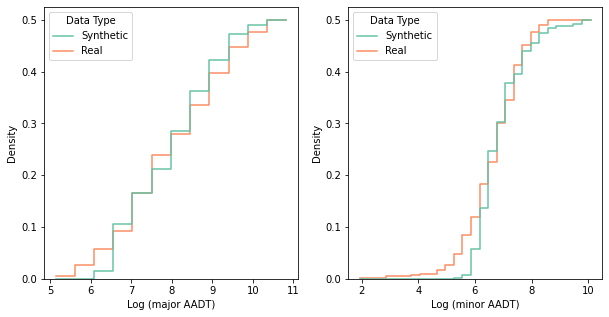

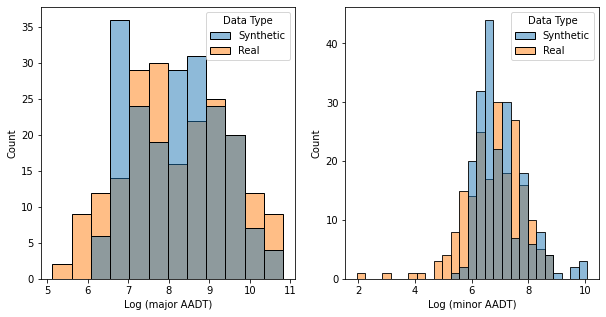

In [185]:
## Plots
import seaborn as sns
fake_sample = fake.sample(200).reset_index()
fake_sample['Data Type'] = 'Synthetic'
real_sample = London_Data.sample(200).reset_index()
real_sample['Data Type'] = 'Real'

data = pd.concat([fake_sample, real_sample]).reset_index(drop=True)
data = data[['Log_Fmin', 'Log_Fmaj', 'Data Type']]
data.columns = ['Log (minor AADT)', 'Log (major AADT)', 'Data Type']



fig, axes = plt.subplots(1,2, figsize=(10,5)) 

sns.boxplot(data = data, y="Log (major AADT)", x="Data Type", ax = axes[0], palette="Set2");
sns.swarmplot(y="Log (major AADT)", x="Data Type", data=data, color=".55", ax = axes[0])
axes[0].set_ylabel('Log (F_maj)')

sns.boxplot(data = data, y="Log (minor AADT)", x="Data Type", ax = axes[1], palette="Set2");
sns.swarmplot(y="Log (minor AADT)", x="Data Type", data=data, color=".55", ax = axes[1])
axes[1].set_ylabel('Log (F_min)')
plt.show()
plt.close()



fig, axes = plt.subplots(1,2, figsize=(10,5)) 

sns.histplot(data, x='Log (major AADT)', hue='Data Type',cumulative=True, stat="density",element="step", palette="Set2",fill=False, ax = axes[0])
sns.histplot(data, x='Log (minor AADT)', hue='Data Type',cumulative=True, stat="density",element="step", palette="Set2",fill=False, ax = axes[1])

fig, axes = plt.subplots(1,2, figsize=(10,5)) 

sns.histplot(data, x='Log (major AADT)', hue='Data Type', ax = axes[0])
sns.histplot(data, x='Log (minor AADT)', hue='Data Type', ax = axes[1])


fig.savefig('dist.pdf')
plt.show()
plt.close()

In [90]:
fake_sample[['Log_Fmin','Log_Fmaj']].describe()

,Log_Fmin,Log_Fmaj
count,200.000000,200.000000
mean,6.442580,7.302068
std,0.854161,0.502729
min,2.794155,5.424281
25%,6.441572,7.074644
50%,6.576623,7.285173
75%,6.914012,7.556959
max,7.453948,9.015095


In [91]:
real_sample[['Log_Fmin','Log_Fmaj']].describe()

,Log_Fmin,Log_Fmaj
count,200.000000,200.000000
mean,6.779492,8.189054
std,1.003524,1.278557
min,1.945910,5.135798
25%,6.195424,7.278456
50%,6.861698,8.029595
75%,7.521588,9.242725
max,8.731498,10.729657
